In [1]:
import numpy as np
import numpy.linalg as nla
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Exercise 3.17

Repeat the analysis of Table 3.3 on the spam data discussed in Chapter 1.

# Solution

Some useful functions we will use in the notebook,

In [2]:
# The features are centralised and standardised
def standardizing(X,X_test):
    mu = np.mean(X,axis=0)
    sig = np.std(X,axis=0)
    return (X-mu)/sig, ((X_test-mu)/sig)

# Regularization parameters
def reg_range(min_exp,max_exp):
    reg_params=[]
    
    for i in range(min_exp,max_exp):
        reg_params.append(10**i)
        reg_params.append(2*10**i)
        reg_params.append(5*10**i)
        
    return reg_params

def Kfold_crossvalidation(X,y,K):
    
    N,_ = X.shape
    val_batch = N//K
    
    data_set = []
    
    for i in range(K):
        X_val = X[val_batch*i:val_batch*(i+1)]
        y_val = y[val_batch*i:val_batch*(i+1)]

        X_train = np.concatenate((X[:val_batch*i],X[val_batch*(i+1):]))
        y_train = np.concatenate((y[:val_batch*i],y[val_batch*(i+1):]))
        
        data_set.append((X_train,y_train,X_val,y_val))
        
    return data_set

def MSE_error(y,y_predict):
    N = y.size
    res_square = (y - y_predict)**2
    return np.mean(res_square)

def error_summary(model,reg_type,X,y,X_test,y_test,error_dict,CV_std_err=-1):
    # Training error
    y_predict_train = model.predict(X)
    train_error = MSE_error(y,y_predict_train)

    # Test error
    y_predict_test = model.predict(X_test)
    test_error = MSE_error(y_test,y_predict_test)

    print('Training error = {:.3f}'.format(train_error))
    print('Test error = {:.3f}'.format(test_error))

    error_dict[reg_type] = (test_error, CV_std_err)

### Load the data and preprocess them

In [3]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data'
dataset = pd.read_csv(url_link, sep=' ',header=None)

# Divide between the training set and the test set
train_dataset = dataset.sample(frac=0.7,random_state=140590)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.tail()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
1240,0.00,0.19,0.00,0.0,0.68,0.09,0.09,0.00,0.29,0.09,...,0.000,0.030,0.000,0.060,0.045,0.0,1.597,20,329,1
197,0.17,0.00,0.08,0.0,0.42,0.08,0.08,0.42,0.08,0.08,...,0.000,0.081,0.027,0.108,0.013,0.0,4.070,48,574,1
4401,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.0,1.571,5,11,0
4009,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.0,2.160,11,54,0
2907,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.675,1.351,0.000,0.000,0.000,0.0,3.700,26,37,0


In [4]:
# Get features and labels
y = train_dataset.pop(57).to_numpy()
y_test = test_dataset.pop(57).to_numpy()

# We standardize the input accoding to the training distribution
X, X_test = standardizing(train_dataset.to_numpy(), test_dataset.to_numpy())

## Test and Std Error for different methods

In [5]:
error_dict = {}

## Least Square Fit (SKLearn)

In [6]:
model = LinearRegression()
model.fit(X,y)

error_summary(model,'LSR',X,y,X_test,y_test,error_dict)

Training error = 0.103
Test error = 0.115


## Least Square Fit (via Normal Equation)

In [7]:
# Linear regression via Normal Equation
class My_LSR():
    
    def fit(self,X,y):
        N,_ = X.shape
        X1 = np.hstack((np.ones((N,1)),X))

        # Computing the optimal estimator
        self.beta = nla.pinv(X1.T @ X1) @ X1.T @ y
        
    def predict(self,X):
        N,_ = X.shape
        X1 = np.hstack((np.ones((N,1)),X))
        
        return X1 @ self.beta

In [8]:
model = My_LSR()
model.fit(X,y)

error_summary(model,'LSR_normal_eq',X,y,X_test,y_test,error_dict)

Training error = 0.103
Test error = 0.115


## Ridge regression

We use K-fold cross validation to select the optimal regularisation parameter

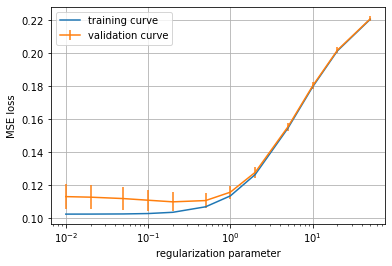

In [9]:
K = 10

# list of regularisation parameters
reg_params = reg_range(-2,2)

train_curve = []
val_curve = []
val_curve_SE = []

for reg_param in reg_params:
    train_error_cv = []
    val_error_cv = []
    
    for X_train,y_train,X_val,y_val in Kfold_crossvalidation(X,y,K):
        
        N, _ = X_train.shape
        model = Ridge(alpha=N*reg_param) # Multiply by N due to form of loss used in Ridge
        model.fit(X_train,y_train)

        # Training error
        y_predict_train = model.predict(X_train)
        train_error = MSE_error(y_train,y_predict_train)
        train_error_cv.append(train_error)

        # Validation error
        y_predict_val = model.predict(X_val)
        val_error = MSE_error(y_val,y_predict_val)
        val_error_cv.append(val_error)
        
    train_curve.append(np.mean(train_error_cv))
    val_curve.append(np.mean(val_error_cv))
    val_curve_SE.append(np.std(val_error_cv)/np.sqrt(K))
    
plt.plot(reg_params,train_curve,label='training curve')
plt.errorbar(reg_params,val_curve,yerr=val_curve_SE,label='validation curve')
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()
plt.show()

Using one-std-error rule, we can select reg = .5 as regularization parameter.

### Test error for ridge with optimal parameter

In [10]:
opt_param = reg_params[5]
CV_std_err = val_curve_SE[5]

N,_ = X.shape

model = Ridge(alpha=N*opt_param)
model.fit(X,y)

error_summary(model,'Ridge',X,y,X_test,y_test,error_dict,CV_std_err)

Training error = 0.107
Test error = 0.118


## Lasso

Again, let us first work out the value of the regularization parameter

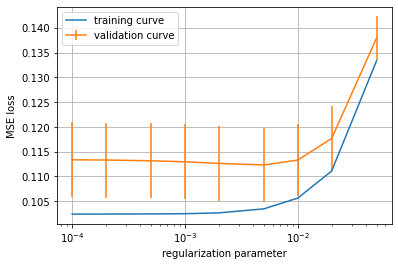

In [11]:
K = 10

# list of regularisation parameters
reg_params = reg_range(-4,-1)

train_curve = []
val_curve = []
val_curve_SE = []

for reg_param in reg_params:
    train_error_cv = []
    val_error_cv = []
    
    for X_train,y_train,X_val,y_val in Kfold_crossvalidation(X,y,K):
        model = Lasso(alpha=reg_param,max_iter=int(1e5))
        model.fit(X_train,y_train)

        # Training error
        y_predict_train = model.predict(X_train)
        train_error = MSE_error(y_train,y_predict_train)
        train_error_cv.append(train_error)

        # Validation error
        y_predict_val = model.predict(X_val)
        val_error = MSE_error(y_val,y_predict_val)
        val_error_cv.append(val_error)
        
    train_curve.append(np.mean(train_error_cv))
    val_curve.append(np.mean(val_error_cv))
    val_curve_SE.append(np.std(val_error_cv)/np.sqrt(K))
    
plt.plot(reg_params,train_curve,label='training curve')
plt.errorbar(reg_params,val_curve,yerr=val_curve_SE,label='validation curve')
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()
plt.show()

Using the one-std-error rule, we can go for reg = 0.02

### Test error for Lasso with optimal parameter

In [12]:
opt_param = reg_params[-2]
CV_std_err = val_curve_SE[-2]

model = Lasso(alpha=opt_param,max_iter=int(1e5))
model.fit(X,y)

error_summary(model,'Lasso',X,y,X_test,y_test,error_dict,CV_std_err)

Training error = 0.111
Test error = 0.125


## Principal component regression

In [13]:
# Principal component regression
class My_PCR():
    
    def __init__(self,M):
        self.M = M
    
    def fit(self,X,y):
        _,_,Vt = nla.svd(X)
        
        self.V = Vt.T
        Z = X @ self.V
        self.theta = (Z.T @ y) / np.diag(Z.T @ Z)
        
        self.intercept = np.mean(y)
        
    def predict(self,X,M=None):
        
        if not M:
            M = self.M
        
        # Take the first M components of the theta vector
        VM = self.V[:,:M]
        thetaM = self.theta[:M]
        
        # Compute the beta parameter
        beta = thetaM @ VM.T
        beta = np.insert(beta,0,self.intercept)
        
        # Predict the outcomes
        N,_ = X.shape
        X1 = np.hstack((np.ones((N,1)),X))
        
        return X1 @ beta

Let us first work out the value of the regularization parameter M (number of component to keep)

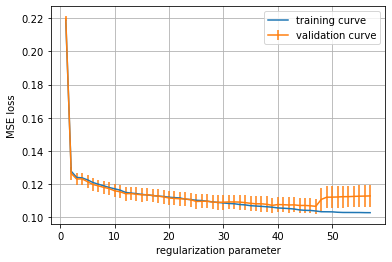

In [14]:
K = 10

# list of components
_,M = X.shape
components = list(range(1,M+1))

train_error_cv = []
val_error_cv = []

# For computational pourposes, we invert the for-loop here,
for X_train,y_train,X_val,y_val in Kfold_crossvalidation(X,y,K):
    
    model = My_PCR(None)
    model.fit(X_train,y_train)
    
    train_error_cmpt = []
    val_error_cmpt = []

    for m in components:

        # Training error
        y_predict_train = model.predict(X_train,m)
        train_error = MSE_error(y_train,y_predict_train)
        train_error_cmpt.append(train_error)

        # Validation error
        y_predict_val = model.predict(X_val,m)
        val_error = MSE_error(y_val,y_predict_val)
        val_error_cmpt.append(val_error)
        
    train_error_cv.append(train_error_cmpt)
    val_error_cv.append(val_error_cmpt)
    
train_curve = np.mean(train_error_cv,axis=0)
val_curve = np.mean(val_error_cv,axis=0)
val_curve_SE = np.std(val_error_cv,axis=0)/np.sqrt(K)
    
plt.plot(components,train_curve,label='training curve')
plt.errorbar(components,val_curve,yerr=val_curve_SE,label='validation curve')
plt.xlabel('regularization parameter')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()
plt.show()

Using the one-standard-error rule, we can select approx 25-30 components.

In [15]:
opt_components = 25
CV_std_err = val_curve_SE[24]

model = My_PCR(M=opt_components)
model.fit(X,y)

error_summary(model,'PCR',X,y,X_test,y_test,error_dict,CV_std_err)

Training error = 0.110
Test error = 0.122


## Partial Least Square regression

In [16]:
# Partial least square algorithm
class My_PLS():
    
    def __init__(self,M):
        self.M = M
    
    def fit(self,X,y):
        
        N,p = X.shape

        y_m = np.full(N,np.mean(y))
        X_m = X.copy()

        y_vect = []
        for _ in range(p):
            phi_m = X_m.T @ y
            z_m = X_m @ phi_m
            theta_m = (z_m.T @ y)/(z_m.T @ z_m)
            y_m += theta_m * z_m
            y_vect.append(y_m.copy())
            coeff_m = (z_m.T @ X_m)/(z_m.T @ z_m)
            X_m -= coeff_m * np.broadcast_to(z_m,(p,N)).T
            
        V = nla.pinv(X)
        
        self.beta_vect = []
        for y_M in y_vect:
            beta = V @ y_M
            beta = np.insert(beta,0,np.mean(y))
            self.beta_vect.append(beta)
            
    def predict(self,X,M=None):
        
        if not M:
            M = self.M
        
        N,_ = X.shape
        X1 = np.hstack((np.ones((N,1)),X))
        
        return X1 @ self.beta_vect[M-1]

Let us first work out the value of the regularization parameter M (number of component to keep)

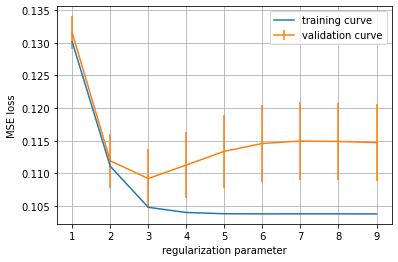

In [17]:
K = 10

# list of components
M = 10
components = list(range(1,M))

train_error_cv = []
val_error_cv = []

# For computational pourposes, we invert the for-loop here,
for X_train,y_train,X_val,y_val in Kfold_crossvalidation(X,y,K):
    
    model = My_PLS(None)
    model.fit(X_train,y_train)
    
    train_error_cmpt = []
    val_error_cmpt = []

    for m in components:

        # Training error
        y_predict_train = model.predict(X_train,m)
        train_error = MSE_error(y_train,y_predict_train)
        train_error_cmpt.append(train_error)

        # Validation error
        y_predict_val = model.predict(X_val,m)
        val_error = MSE_error(y_val,y_predict_val)
        val_error_cmpt.append(val_error)
        
    train_error_cv.append(train_error_cmpt)
    val_error_cv.append(val_error_cmpt)
    
train_curve = np.mean(train_error_cv,axis=0)
val_curve = np.mean(val_error_cv,axis=0)
val_curve_SE = np.std(val_error_cv,axis=0)/np.sqrt(K)
    
plt.plot(components,train_curve,label='training curve')
plt.errorbar(components,val_curve,yerr=val_curve_SE,label='validation curve')
plt.xlabel('regularization parameter')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()
plt.show()

Using the std-err-rule, we can take 2 components,

In [18]:
opt_components = 2
CV_std_err = val_curve_SE[1]

model = My_PLS(M=opt_components)
model.fit(X,y)

error_summary(model,'PLS',X,y,X_test,y_test,error_dict,CV_std_err)

Training error = 0.110
Test error = 0.127


### Results

In [21]:
for key in error_dict.keys():
    
    print('{} method gives test error = {:.3f}'.format(key,error_dict[key][0]))
    if error_dict[key][1] != -1:
        print('CV standard error = {:.3f}'.format(error_dict[key][1]))

LSR method gives test error = 0.115
LSR_normal_eq method gives test error = 0.115
Ridge method gives test error = 0.118
CV standard error = 0.005
Lasso method gives test error = 0.125
CV standard error = 0.007
PCR method gives test error = 0.122
CV standard error = 0.004
PLS method gives test error = 0.127
CV standard error = 0.004
